Quantitative Analysis of Price & Daily returns
 - Are the changes in prices like the way things usually spread out in a regular pattern?
 - Do the changes in prices have a tendency to go in one direction more often? 
 - Are price movements kind of like taking random steps?

In [1]:
#1.Set up environment
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import datetime
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()

In [2]:
#2.Download Stock price data, store the dataFrame
def get_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data

start = datetime(2020, 1, 1)
end = datetime(2023, 7, 31)
aapl_data = get_stock_data("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
aapl_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347939,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634834,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213615,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869278,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041489,132079200


In [4]:
#3.Store instantaneous rate of return in separate series
aapl = get_stock_data("AAPL", start, end)
aapl_close = aapl['Close']
#aapl_return = np.log(aapl_close).diff()
aapl_return = round(np.log(aapl_close).diff() * 100, 2)
aapl_return.head()

[*********************100%***********************]  1 of 1 completed


Date
2020-01-02     NaN
2020-01-03   -0.98
2020-01-06    0.79
2020-01-07   -0.47
2020-01-08    1.60
Name: Close, dtype: float64

<Axes: xlabel='Date'>

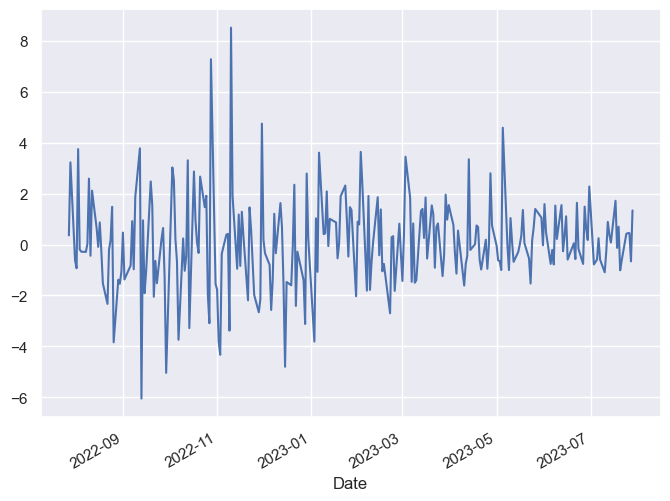

In [5]:
#4.Plot the series
aapl_return[-252:].plot()

In [6]:
#5.Pandas describe funtion gives descriptive statustucs, default assumens you are dealing with a sample Pandas also deals with missing values by omitting them
aapl_return.dropna(inplace = True)
aapl_return.describe()

count    898.000000
mean       0.106682
std        2.194423
min      -13.770000
25%       -0.950000
50%        0.080000
75%        1.340000
max       11.320000
Name: Close, dtype: float64

In [7]:
#An alternative more slightly different table of descriptives from scipy stats
from scipy import stats
n, minmax, mean, var, skew, kurt = stats.describe(aapl_return)
mini, maxi = minmax
std = var ** .5

In [8]:
#For comparision generate random numbers that follow normal distribution
from scipy.stats import norm

(array([  1.,   0.,   1.,   2.,   8.,  23.,  74., 229., 324., 175.,  45.,
          7.,   3.,   4.,   2.]),
 array([-13.77      , -12.09733333, -10.42466667,  -8.752     ,
         -7.07933333,  -5.40666667,  -3.734     ,  -2.06133333,
         -0.38866667,   1.284     ,   2.95666667,   4.62933333,
          6.302     ,   7.97466667,   9.64733333,  11.32      ]),
 <BarContainer object of 15 artists>)

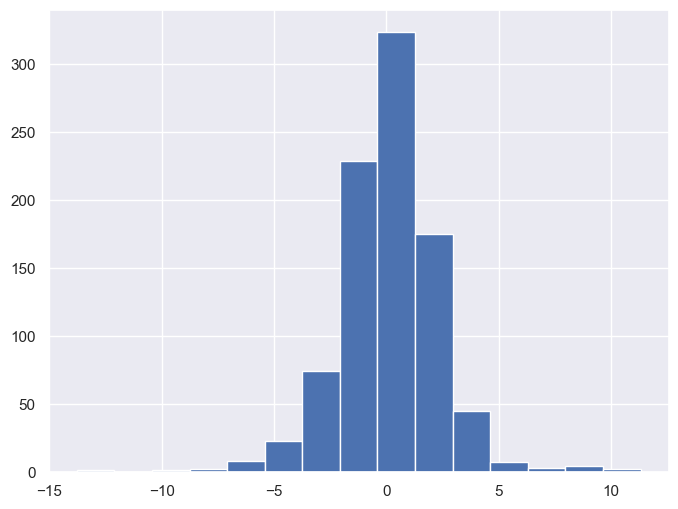

In [9]:
plt.hist(aapl_return, bins = 15)

In [10]:
from scipy.stats import norm
x = norm.rvs(mean, std, n)

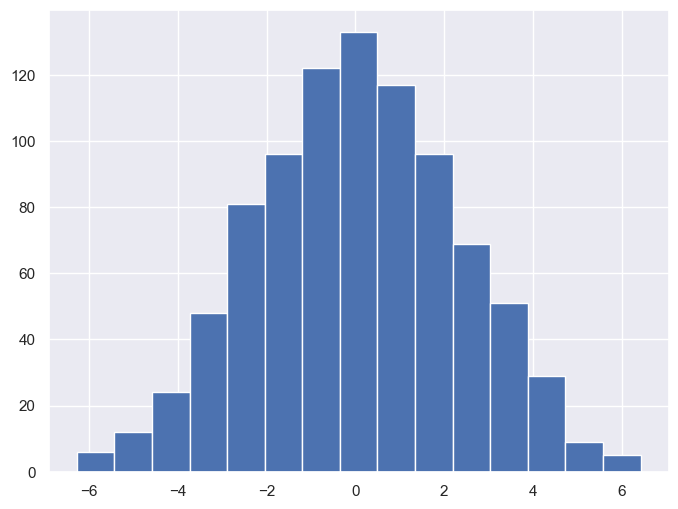

In [11]:
plt.hist(x, bins =15);

Do the changes in prices follow a regular pattern?
We're using a tool called scipy stats to test something called "kurtosis." This helps us check if the way prices change fits with how things usually spread out in a predictable way. The idea is, if the test suggests that the prices match a certain pattern, it's like saying they're similar to how things like heights usually spread out in a familiar way.

In [12]:
x_test = stats.kurtosistest(x)
aapl_test = stats.kurtosistest(aapl_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"_"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AAPL:{aapl_test[0]:13.2f}{aapl_test[1]:16.4f}")

     Test statistic         p-value
     ______________________________
x:            -1.72          0.0860
AAPL:         9.99          0.0000


Plot histogram of price changes with normal curve overlay

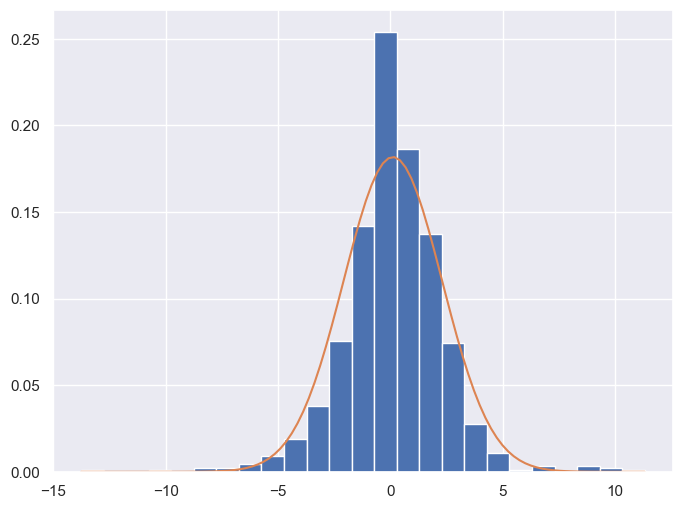

In [13]:
plt.hist(aapl_return, bins = 25, edgecolor= 'w', density = True)
overlay = np.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std));

Is daily price change significantly different from zero?

Conduct simple hypothesis test

In [14]:
stats.ttest_1samp(aapl_return, 0, alternative = 'two-sided')

TtestResult(statistic=1.4568237689092798, pvalue=0.1455149849714069, df=897)

Can price movement be described as a random walk?

Create price lags

In [15]:
aapl_close = pd.DataFrame(aapl.Close, columns= ['Close'])
aapl_close['lag_1'] = aapl_close.Close.shift(1)
aapl_close['lag_2'] = aapl_close.Close.shift(2)
aapl_close.dropna(inplace = True)
aapl_close.head()

,Close,lag_1,lag_2
Date,,,
2020-01-06,74.949997,74.357498,75.087502
2020-01-07,74.597504,74.949997,74.357498
2020-01-08,75.797501,74.597504,74.949997
2020-01-09,77.407501,75.797501,74.597504
2020-01-10,77.582497,77.407501,75.797501


Fit linear model

In [16]:
lr = np.linalg.lstsq(aapl_close[['lag_1', 'lag_2']], aapl_close.Close, rcond=None)[0]


In [17]:
aapl_close['predict'] = np.dot(aapl_close[['lag_1', 'lag_2']], lr)

In [18]:
aapl_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2020-01-06,74.949997,74.357498,75.087502,74.460654
2020-01-07,74.597504,74.949997,74.357498,74.976939
2020-01-08,75.797501,74.597504,74.949997,74.678962
2020-01-09,77.407501,75.797501,74.597504,75.789904
2020-01-10,77.582497,77.407501,75.797501,77.377443


<Axes: xlabel='Date'>

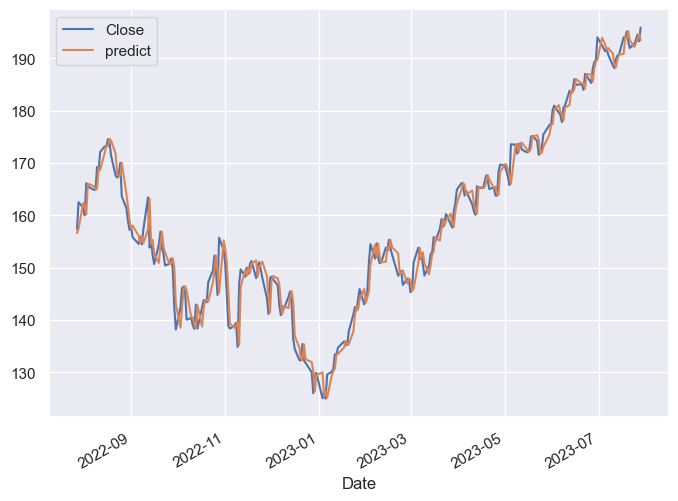

In [19]:
aapl_close.iloc[-252:][['Close', 'predict']].plot()